# TP2 Heart Disease #Santé (partie 2)
## Prédiction des patients atteints de maladie cardiovasculaire

Objectif : appréhender et développer toutes les étapes permettant l’utilisation d’une méthode d’apprentissage automatique supervisée

- Exploration de données
- Découper le jeu de données en une partie pour l’apprentissage et l’autre pour le test
- Évaluation et comparaison des différents algorithmes sur les modèles fournis
- Matrice de confusion
- Courbe ROC

Méthodes : 
- Arbre de décision
- Forêts aléatoires


Dans Anaconda Prompt :
- pip install eli5
- pip install sklearn
- pip install pdpbox
- pip install pydotplus

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #for plotting
from sklearn.ensemble import RandomForestClassifier #for the model
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz #plot tree
from sklearn.metrics import roc_curve, auc #for model evaluation
from sklearn.metrics import classification_report #for model evaluation
from sklearn.metrics import confusion_matrix #for model evaluation
from sklearn.model_selection import train_test_split #for data splitting
import eli5 #for purmutation importance
from eli5.sklearn import PermutationImportance
#import shap #for SHAP values
from pdpbox import pdp, info_plots #for partial plots
import pydotplus
np.random.seed(123) #ensure reproducibility

pd.options.mode.chained_assignment = None  #hide any pandas warnings

<a id='section2'></a>

In [5]:
df = pd.read_csv("heart.csv")

In [6]:
#Renommer les noms de colonnes
df.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar', 'rest_ecg', 'max_heart_rate_achieved',
       'exercise_induced_angina', 'st_depression', 'st_slope', 'num_major_vessels', 'thalassemia', 'target']

In [7]:
#Définir les types appropriés : les variables numériques discrètes deviennent de type object car elles ne sont pas continues
df['sex'] = df['sex'].astype('object')
df['chest_pain_type'] = df['chest_pain_type'].astype('object')
df['fasting_blood_sugar'] = df['fasting_blood_sugar'].astype('object')
df['rest_ecg'] = df['rest_ecg'].astype('object')
df['exercise_induced_angina'] = df['exercise_induced_angina'].astype('object')
df['st_slope'] = df['st_slope'].astype('object')
df['thalassemia'] = df['thalassemia'].astype('object')

In [8]:
#Vérification des nouveaux types
df.dtypes

age                          int64
sex                         object
chest_pain_type             object
resting_blood_pressure       int64
cholesterol                  int64
fasting_blood_sugar         object
rest_ecg                    object
max_heart_rate_achieved      int64
exercise_induced_angina     object
st_depression              float64
st_slope                    object
num_major_vessels            int64
thalassemia                 object
target                       int64
dtype: object

Note : target ne doit pas passer en objet sinon message d'erreur dans l'arbre de décision

<a id='section3'></a>

### Base d'apprentissage et de test

La base d'apprentissage et de test sont respectivement de 80% et 20% du jeu de données. 

In [6]:
#split the data
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', 1), 
                                                    df['target'], 
                                                    test_size = .2, 
                                                    random_state=10) 

In [7]:
#Nombre de lignes dans le jeu d'apprentissage
X_train.shape[0]

242

In [8]:
#Nombre de lignes dans le jeu de test
X_test.shape[0]

61

# Arbre de décision

In [9]:
#Arbre de décision
dtc = DecisionTreeClassifier()

dtc.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [10]:
#Estime la variable cible de la base de test
y_esti_tree = dtc.predict(X_test)

In [11]:
#Affiche les 10 premiers résultats
y_esti_tree[1:10]

array([0, 0, 1, 1, 1, 1, 0, 1, 1], dtype=int64)

In [12]:
#Matrice de confusion
confusion_matrice_tree = confusion_matrix(y_test, y_esti_tree)

In [13]:
confusion_matrice_tree
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix
#En ligne : les classes réelles
#En colonnes : les classes prédites

array([[25, 10],
       [ 4, 22]], dtype=int64)

In [14]:
tn, fp, fn, tp = confusion_matrix(y_test, y_esti_tree).ravel()
print("True Negative : " + str(tn))
print("False Positive : " + str(fp))
print("False Negative : " + str(fn))
print("True Positive : " + str(tp))

True Negative : 25
False Positive : 10
False Negative : 4
True Positive : 22


\begin{align}
Sensitivity = \frac{True\:Positives}{True\:Positives + False\:Negatives}
\end{align}

In [15]:
sensitivity_tree = confusion_matrice_tree[1,1]/(confusion_matrice_tree[1,1]+confusion_matrice_tree[1,0])

In [16]:
sensitivity_tree

0.8461538461538461

\begin{align}
Specificity = \frac{True\:Negatives}{True\:Negatives + False\:Positives}
\end{align}

In [17]:
specificity_tree = confusion_matrice_tree[0,0]/(confusion_matrice_tree[0,0]+confusion_matrice_tree[0,1])

In [18]:
specificity_tree

0.7142857142857143

In [19]:
#Nombre de prédiction correctes (VP+VN normalisé)
dtc.score(X_test, y_test)

#https://scikit-learn.org/stable/modules/model_evaluation.html#accuracy-score

0.7704918032786885

In [20]:
#Visualisation de l'arbre méthode 1
tree.export_graphviz(dtc)
#http://webgraphviz.com/

#http://viz-js.com/
#tree.export_graphviz(dtc,out_file='graph.txt')

'digraph Tree {\nnode [shape=box] ;\n0 [label="X[2] <= 0.5\\ngini = 0.489\\nsamples = 242\\nvalue = [103, 139]"] ;\n1 [label="X[11] <= 0.5\\ngini = 0.405\\nsamples = 110\\nvalue = [79, 31]"] ;\n0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;\n2 [label="X[8] <= 0.5\\ngini = 0.493\\nsamples = 50\\nvalue = [22, 28]"] ;\n1 -> 2 ;\n3 [label="X[0] <= 41.5\\ngini = 0.32\\nsamples = 25\\nvalue = [5, 20]"] ;\n2 -> 3 ;\n4 [label="X[12] <= 2.5\\ngini = 0.444\\nsamples = 3\\nvalue = [2, 1]"] ;\n3 -> 4 ;\n5 [label="gini = 0.0\\nsamples = 1\\nvalue = [0, 1]"] ;\n4 -> 5 ;\n6 [label="gini = 0.0\\nsamples = 2\\nvalue = [2, 0]"] ;\n4 -> 6 ;\n7 [label="X[7] <= 96.5\\ngini = 0.236\\nsamples = 22\\nvalue = [3, 19]"] ;\n3 -> 7 ;\n8 [label="gini = 0.0\\nsamples = 1\\nvalue = [1, 0]"] ;\n7 -> 8 ;\n9 [label="X[4] <= 271.5\\ngini = 0.172\\nsamples = 21\\nvalue = [2, 19]"] ;\n7 -> 9 ;\n10 [label="gini = 0.0\\nsamples = 16\\nvalue = [0, 16]"] ;\n9 -> 10 ;\n11 [label="X[9] <= 0.85\\ngini = 0.48\\nsam

In [21]:
#Visualisation de l'arbre méthode 2
tree.export_graphviz(dtc, out_file="tree.dot")
with open("tree.dot", 'w') as my_file:
    tree.export_graphviz(dtc)
    
dot_data = tree.export_graphviz(dtc, out_file=None,
            feature_names=X_train.columns,
            class_names=['sick','not sick'],
            filled=True, rounded=True,
            special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_pdf("D:/heart.pdf")

True

- Mettre à jour scikit-learn vers version 0.23.2 (avec anaconda environment
- Installer  graphiviz https://www2.graphviz.org/Packages/development/windows/10/cmake/Release/x64/
- Dans anaconda prompt:  dot -c
- Redemarrer Anaconda
- "dot -c" dans anaconda

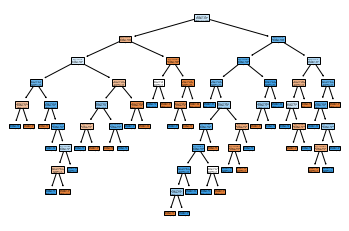

In [22]:
#Visualisation de l'arbre méthode 3
from sklearn.tree import plot_tree
plt.figure()
plot_tree(dtc, filled=True)
plt.show()

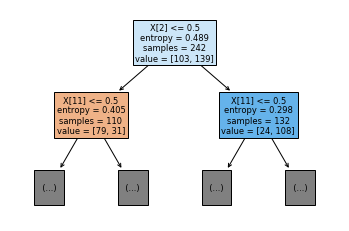

In [23]:
plt.figure()
plot_tree(dtc, filled=True, max_depth=1)
plt.show()

Text(0.5, 1.0, 'Arbre de décision')

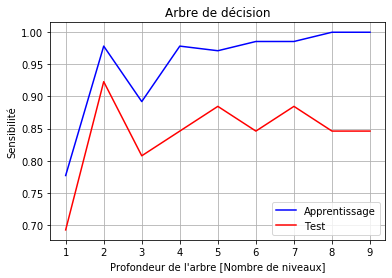

In [24]:
#Analyse de sensibilité
profondeur = dtc.get_depth()
sensi_depth_app = np.ones(profondeur) * np.nan
sensi_depth_test = np.ones(profondeur) * np.nan

for i in range(1,profondeur+1):
    #model
    dtc1 = DecisionTreeClassifier(max_depth=i)
    dtc1.fit(X_train, y_train)
    #predict sur test
    y_esti_tree = dtc1.predict(X_test)
    confusion_matrice = confusion_matrix(y_test, y_esti_tree)
    sensi_depth_test[i-1] = confusion_matrice[1,1]/(confusion_matrice[1,1]+confusion_matrice[1,0])
    #predict sur app
    y_esti_tree = dtc1.predict(X_train)
    confusion_matrice = confusion_matrix(y_train, y_esti_tree)
    sensi_depth_app[i-1] = confusion_matrice[1,1]/(confusion_matrice[1,1]+confusion_matrice[1,0])

plt.grid()
plt.plot(range(1,profondeur+1), sensi_depth_app, color="blue")
plt.plot(range(1,profondeur+1), sensi_depth_test, color="red")
plt.ylabel("Sensibilité")
plt.xlabel("Profondeur de l'arbre [Nombre de niveaux]")
plt.legend(['Apprentissage','Test'])
plt.title('Arbre de décision')

# Random Forest

In [25]:
#le modèle
rf = RandomForestClassifier(max_depth=5)

In [26]:
#Apprentissage
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [27]:
#Prédiction sur les données de tests
y_esti_rf = rf.predict(X_test)

In [28]:
#Affiche les 10 premiers résultats
y_esti_rf[1:10]

array([0, 0, 1, 0, 1, 1, 1, 1, 0], dtype=int64)

In [29]:
#Matrice de confusion
confusion_matrice_rf = confusion_matrix(y_test, y_esti_rf)
confusion_matrice_rf

array([[29,  6],
       [ 3, 23]], dtype=int64)

In [30]:
specificity_rf = confusion_matrice_rf[0,0]/(confusion_matrice_rf[0,0]+confusion_matrice_rf[0,1])
specificity_rf

0.8285714285714286

In [31]:
sensitivity_rf = confusion_matrice_rf[1,1]/(confusion_matrice_rf[1,1]+confusion_matrice_rf[1,0])
sensitivity_rf

0.8846153846153846

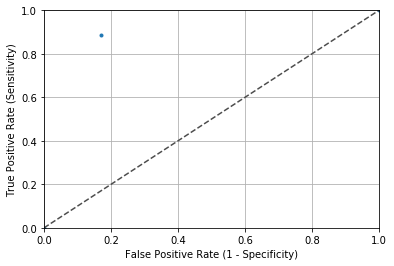

In [32]:
#Projection des résultats d'une matrice de confusion sur l'espace ROC
fpr_pred, tpr_pred, thresholds_pred = roc_curve(y_test, y_esti_rf)

fig, ax = plt.subplots()
ax.plot(fpr_pred, tpr_pred, '.')
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [33]:
#class probability predictions
y_esti_quant_rf = rf.predict_proba(X_test)[:,1]
y_esti_quant_rf

array([0.14337662, 0.35892857, 0.44693182, 0.75980415, 0.28104808,
       0.76666667, 0.62067288, 0.6896063 , 0.91972302, 0.08666667,
       0.86943978, 0.1594824 , 0.44598722, 0.88705882, 0.23825758,
       0.91372549, 0.05859649, 0.02318182, 0.68205882, 0.31      ,
       0.1037013 , 0.7158563 , 0.65355311, 0.92806568, 0.12      ,
       0.29318182, 0.005     , 0.02871795, 0.77380952, 0.005     ,
       0.91787488, 0.15375   , 0.03746753, 0.25809524, 0.        ,
       0.09523998, 0.68809524, 0.45519669, 0.92166667, 0.44571429,
       0.13357143, 0.115     , 0.55423585, 0.535     , 0.96460107,
       0.44879731, 0.625     , 0.81702464, 0.68872549, 0.5052381 ,
       0.30288462, 0.90368871, 0.005     , 0.08015493, 0.98083624,
       0.58785714, 0.69846861, 0.82126707, 0.005     , 0.005     ,
       0.91626984])

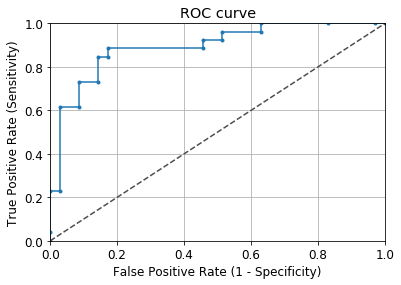

In [34]:
#Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_esti_quant_rf)

fig, ax = plt.subplots()
ax.plot(fpr, tpr, '.-')
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [35]:
#Aire sous la courbe ROC (AUC)
auc(fpr, tpr)

0.8945054945054944

In [36]:
#Nombre de prédiction correctes (VP+VN normalisé)
rf.score(X_test,y_test)

0.8524590163934426

# Permutation importance

In [37]:
perm = PermutationImportance(rf, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.1016 ± 0.0321,chest_pain_type
0.0623 ± 0.0382,thalassemia
0.0525 ± 0.0382,age
0.0426 ± 0.0608,num_major_vessels
0.0295 ± 0.0601,st_depression
0.0295 ± 0.0245,exercise_induced_angina
0.0230 ± 0.0262,sex
0.0197 ± 0.0131,st_slope
0.0131 ± 0.0245,resting_blood_pressure
0.0098 ± 0.0334,max_heart_rate_achieved


In [38]:
#Code pour afficher sur l'IDE (méthode 1)
print(eli5.format_as_text(eli5.explain_weights(perm, feature_names=X_test.columns.tolist())))

Explained as: feature importances

Feature importances, computed as a decrease in score when feature
values are permuted (i.e. become noise). This is also known as 
permutation importance.

If feature importances are computed on the same data as used for training, 
they don't reflect importance of features for generalization. Use a held-out
dataset if you want generalization feature importances.

0.1016 ± 0.0321  chest_pain_type
0.0623 ± 0.0382  thalassemia
0.0525 ± 0.0382  age
0.0426 ± 0.0608  num_major_vessels
0.0295 ± 0.0601  st_depression
0.0295 ± 0.0245  exercise_induced_angina
0.0230 ± 0.0262  sex
0.0197 ± 0.0131  st_slope
0.0131 ± 0.0245  resting_blood_pressure
0.0098 ± 0.0334  max_heart_rate_achieved
0.0066 ± 0.0161  cholesterol
0.0033 ± 0.0131  fasting_blood_sugar
     0 ± 0.0000  rest_ecg


In [ ]:
#Code pour afficher sur l'IDE (méthode 2)
perm = PermutationImportance(rf, random_state=1).fit(X_test, y_test)
html_obj = eli5.show_weights(perm, feature_names = X_test.columns.tolist())
with open('permutation-importance.htm','wb') as f:
    f.write(html_obj.data.encode("UTF-8"))

In [39]:
#Analyse de sensibilité 
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier

rf_model = RandomForestClassifier()

parameters = [{"n_estimators":[1,5,10,20,50], 'max_depth': [2, 5, 10, 15]}]
grid_bag = GridSearchCV(estimator=rf_model, param_grid=parameters, cv=5, scoring="recall")

grid = grid_bag.fit(X_train, y_train)

In [40]:
grid.best_score_

0.9426680222134767

In [41]:
grid.best_params_

{'max_depth': 2, 'n_estimators': 50}